In [1]:
# pip install optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('input/spotify_songs.csv', sep=',')

songs = df[['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
print(songs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   playlist_genre    32833 non-null  object 
 1   danceability      32833 non-null  float64
 2   energy            32833 non-null  float64
 3   key               32833 non-null  int64  
 4   loudness          32833 non-null  float64
 5   mode              32833 non-null  int64  
 6   speechiness       32833 non-null  float64
 7   acousticness      32833 non-null  float64
 8   instrumentalness  32833 non-null  float64
 9   liveness          32833 non-null  float64
 10  valence           32833 non-null  float64
 11  tempo             32833 non-null  float64
 12  duration_ms       32833 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 3.3+ MB
None


In [3]:
songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [4]:
# Remove duplicates
duplicates = songs.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

songs_no_duplicates = songs.drop_duplicates()


Number of duplicate rows:  3041


We have performed tests with and without removing duplicated rows. Turns out leaving duplicates yields much better result (almost 5% improvement for some models).

In [5]:
print("Total number of songs: ", len(songs))
print(songs['playlist_genre'].value_counts())

Total number of songs:  32833
playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64


In [6]:
min = songs['playlist_genre'].value_counts().min()
# Take only min songs from each genre
songs_grouped = songs.groupby('playlist_genre').head(min)

In [7]:
map_genres = {genre: i for i, genre in enumerate(songs_grouped['playlist_genre'].unique())}
map_genres 

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}

In [8]:
songs_mapped = songs_grouped.copy()
songs_mapped['playlist_genre'] = songs_mapped['playlist_genre'].map(map_genres)

# Confusions caused by duplicates


In [9]:
data_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

grouped_by_data = songs_mapped.groupby(data_columns)
# result_list_of_lists = [group['playlist_genre'].values for _, group in grouped_by_data]
result_list_of_lists = [np.unique(group['playlist_genre'].values) for _, group in grouped_by_data]

In [10]:
# empty numpy array
real = []
predicted = []
for lst in result_list_of_lists:
    for i in range(len(lst)):
        for j in range(i+1, len(lst)):
            if lst[i] == lst[j]:
                continue
            real.append(lst[i])
            predicted.append(lst[j])
            real.append(lst[j])
            predicted.append(lst[i])

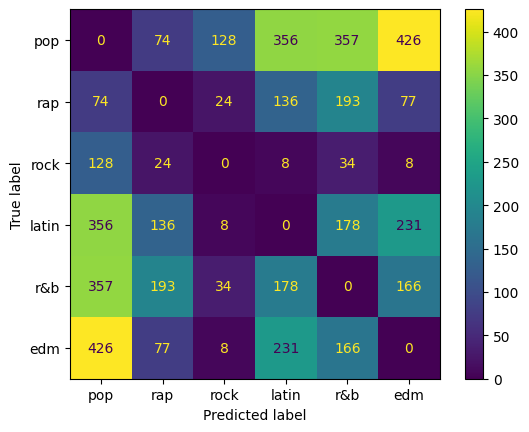

In [11]:
conf_matrix = confusion_matrix(real,predicted)

disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

In [12]:
songs_data_non_normalized = songs_grouped.drop('playlist_genre', axis=1)
songs_target = songs_grouped['playlist_genre']
songs_target = songs_target.map(map_genres)

# Normalize data to 0-1 range
songs_data = (songs_data_non_normalized - songs_data_non_normalized.min()) / (songs_data_non_normalized.max() - songs_data_non_normalized.min())

songs_data_train, songs_data_test, songs_target_train, songs_target_test = train_test_split(songs_data, songs_target, test_size=0.3, random_state=0)
songs_data_test, songs_data_val, songs_target_test, songs_target_val = train_test_split(songs_data_test, songs_target_test, test_size=0.5, random_state=0)

print("Training set size: ", len(songs_data_train))
print("Test set size: ", len(songs_data_test))
print("Validation set size: ", len(songs_data_val))

Training set size:  20794
Test set size:  4456
Validation set size:  4456


In [13]:
# only train-test split (for cross validation)
songs_data_train2, songs_data_test2, songs_target_train2, songs_target_test2 = train_test_split(songs_data, songs_target, test_size=0.15, random_state=0)

print("Training set size: ", len(songs_data_train2))
print("Test set size: ", len(songs_data_test2))

Training set size:  25250
Test set size:  4456


# Data analysis

In [22]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms']

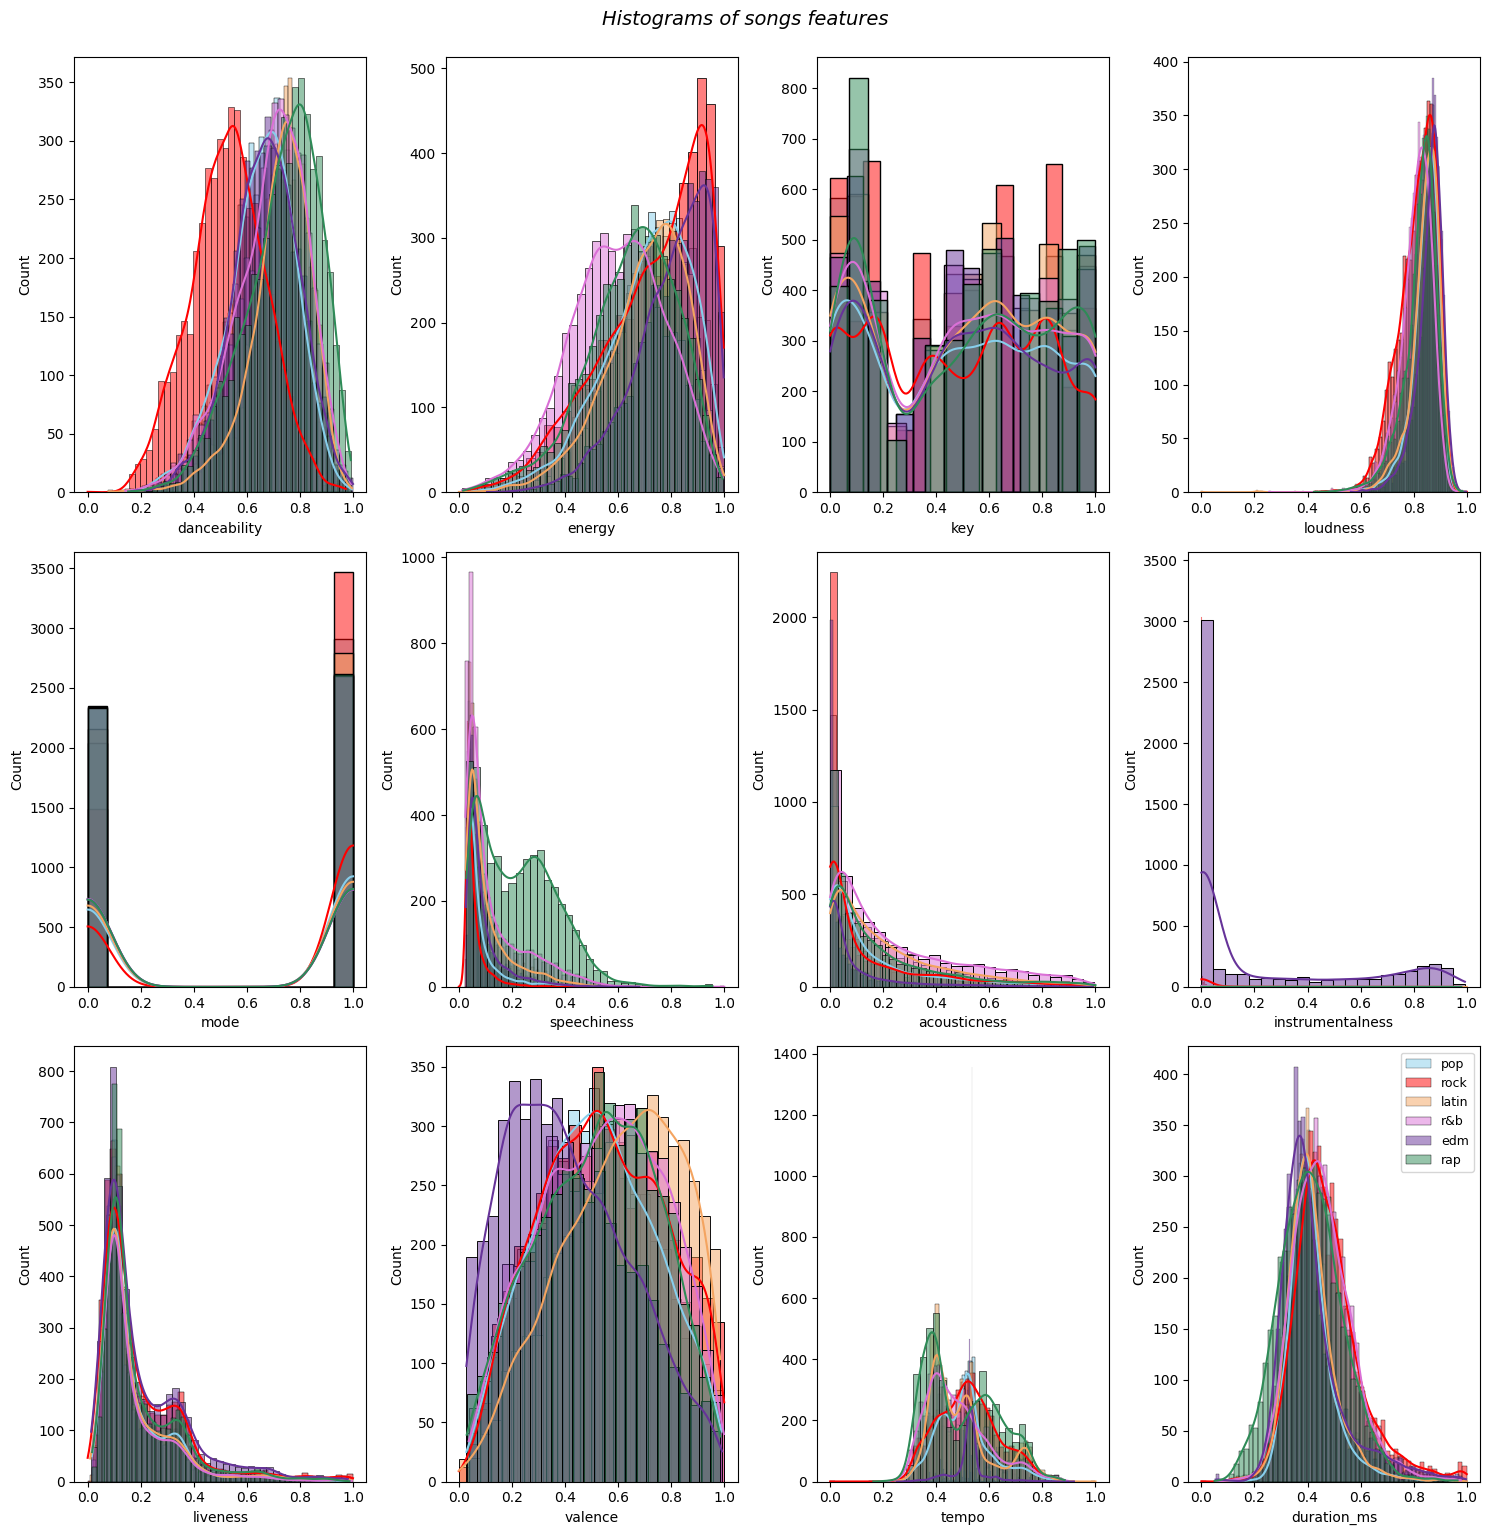

In [23]:
# normalized data
songs_data_and_target = songs_data.copy()
songs_data_and_target['playlist_genre'] = songs_grouped['playlist_genre']
pop_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='pop']
rock_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rock']
latin_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='latin']
r_and_b_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='r&b']
edm_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='edm']
rap_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9') #bbox_to_anchor=(1, 0)
#sns.move_legend(loc="lower center", bbox_to_anchor=(.5, 0), ncol=6, title=None, frameon=False)
plt.show()

conclusions?

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


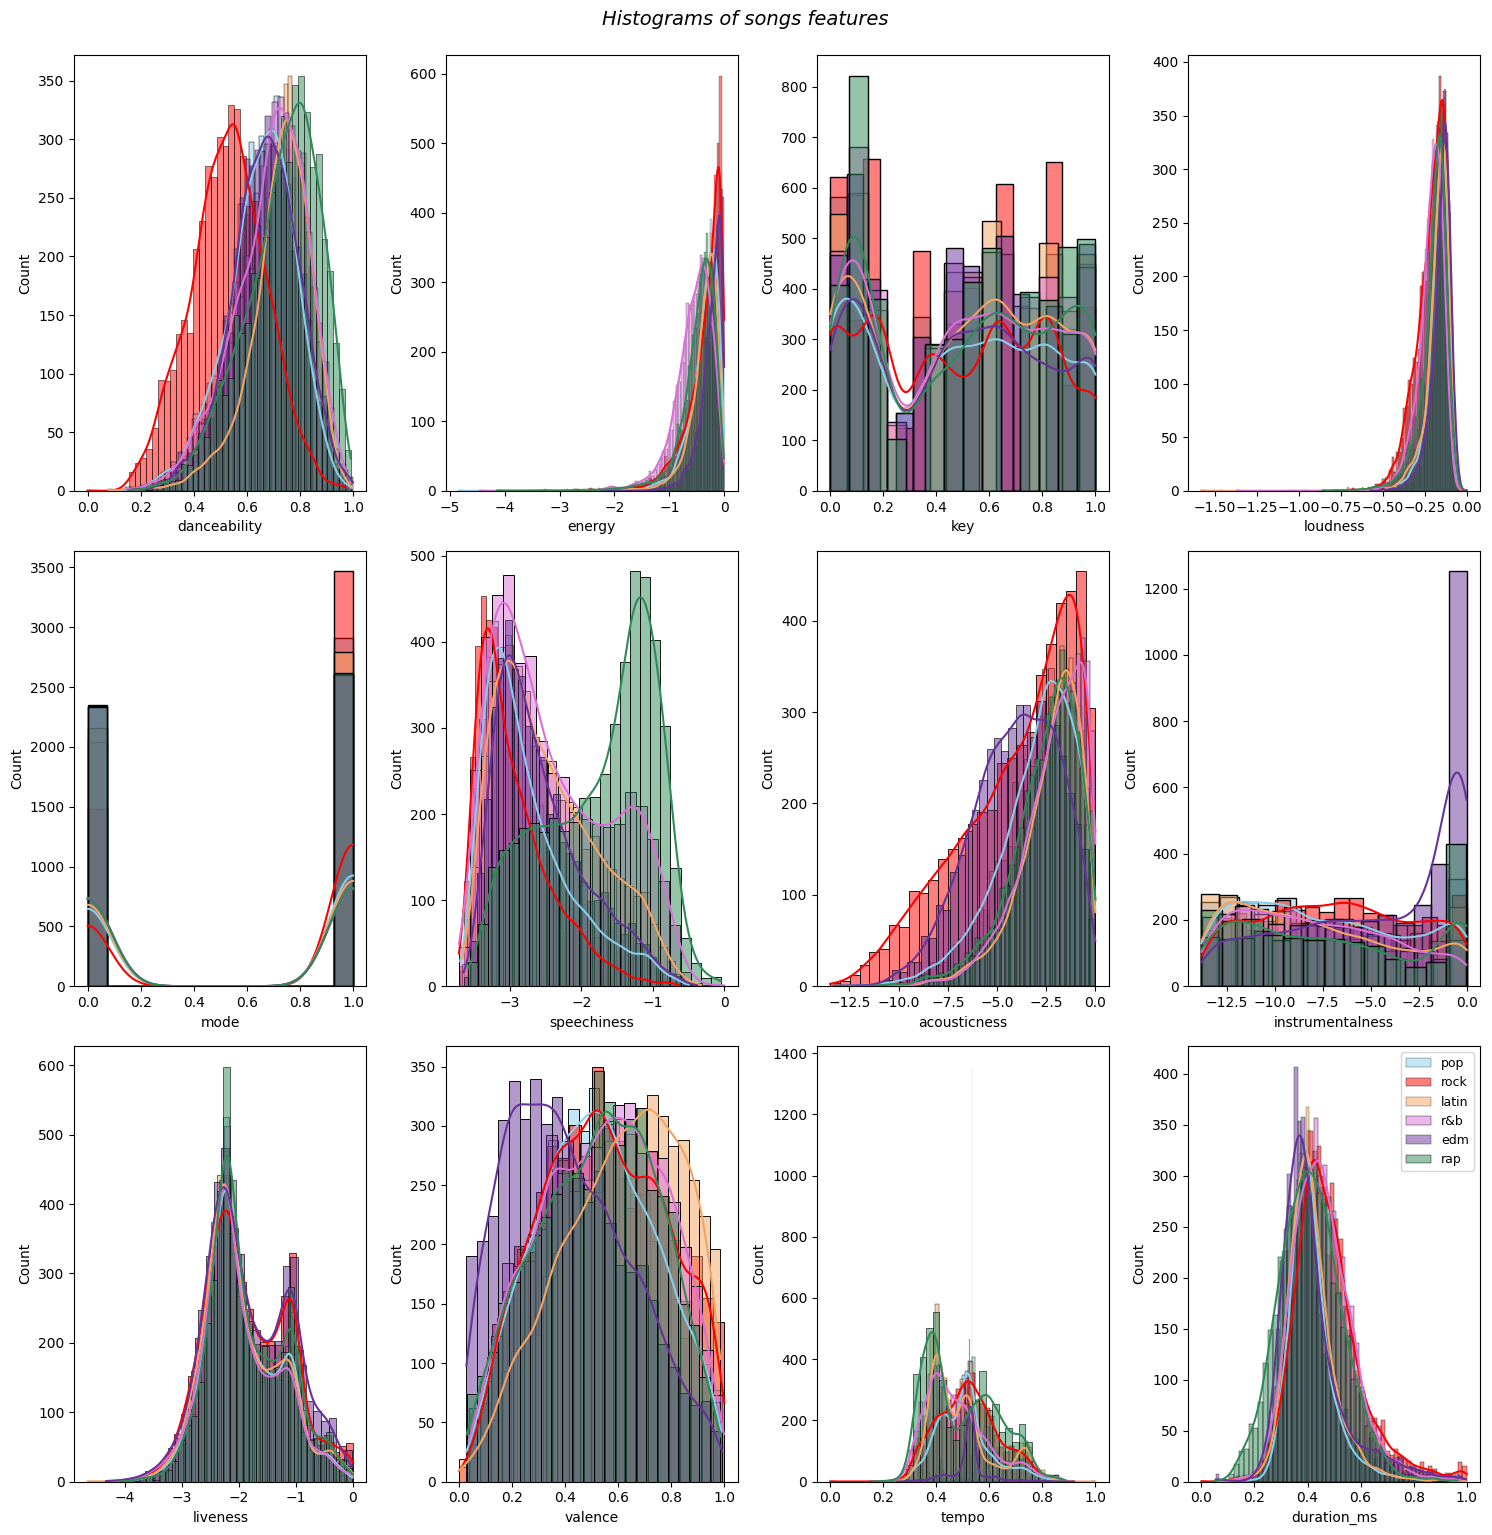

In [24]:
# normalized data + log transformation
songs_data_and_target = songs_data.copy()

songs_data_and_target['energy'] = np.log(songs_data_and_target['energy'])
songs_data_and_target['loudness'] = np.log(songs_data_and_target['loudness'])
songs_data_and_target['speechiness'] = np.log(songs_data_and_target['speechiness'])
songs_data_and_target['acousticness'] = np.log(songs_data_and_target['acousticness'])
songs_data_and_target['instrumentalness'] = np.log(songs_data_and_target['instrumentalness'])
songs_data_and_target['liveness'] = np.log(songs_data_and_target['liveness'])

songs_data_and_target['playlist_genre'] = songs_grouped['playlist_genre']
pop_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='pop']
rock_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rock']
latin_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='latin']
r_and_b_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='r&b']
edm_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='edm']
rap_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

    # plt.yscale('log')

plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9') #bbox_to_anchor=(1, 0)
#sns.move_legend(loc="lower center", bbox_to_anchor=(.5, 0), ncol=6, title=None, frameon=False)
plt.show()

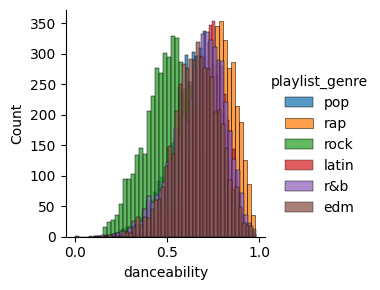

In [25]:
# different way to do the histogram (it is here just in case I want to change sth)
g = sns.FacetGrid(songs_grouped, hue="playlist_genre")
g.map(sns.histplot, "danceability") # kde=True
g.add_legend()

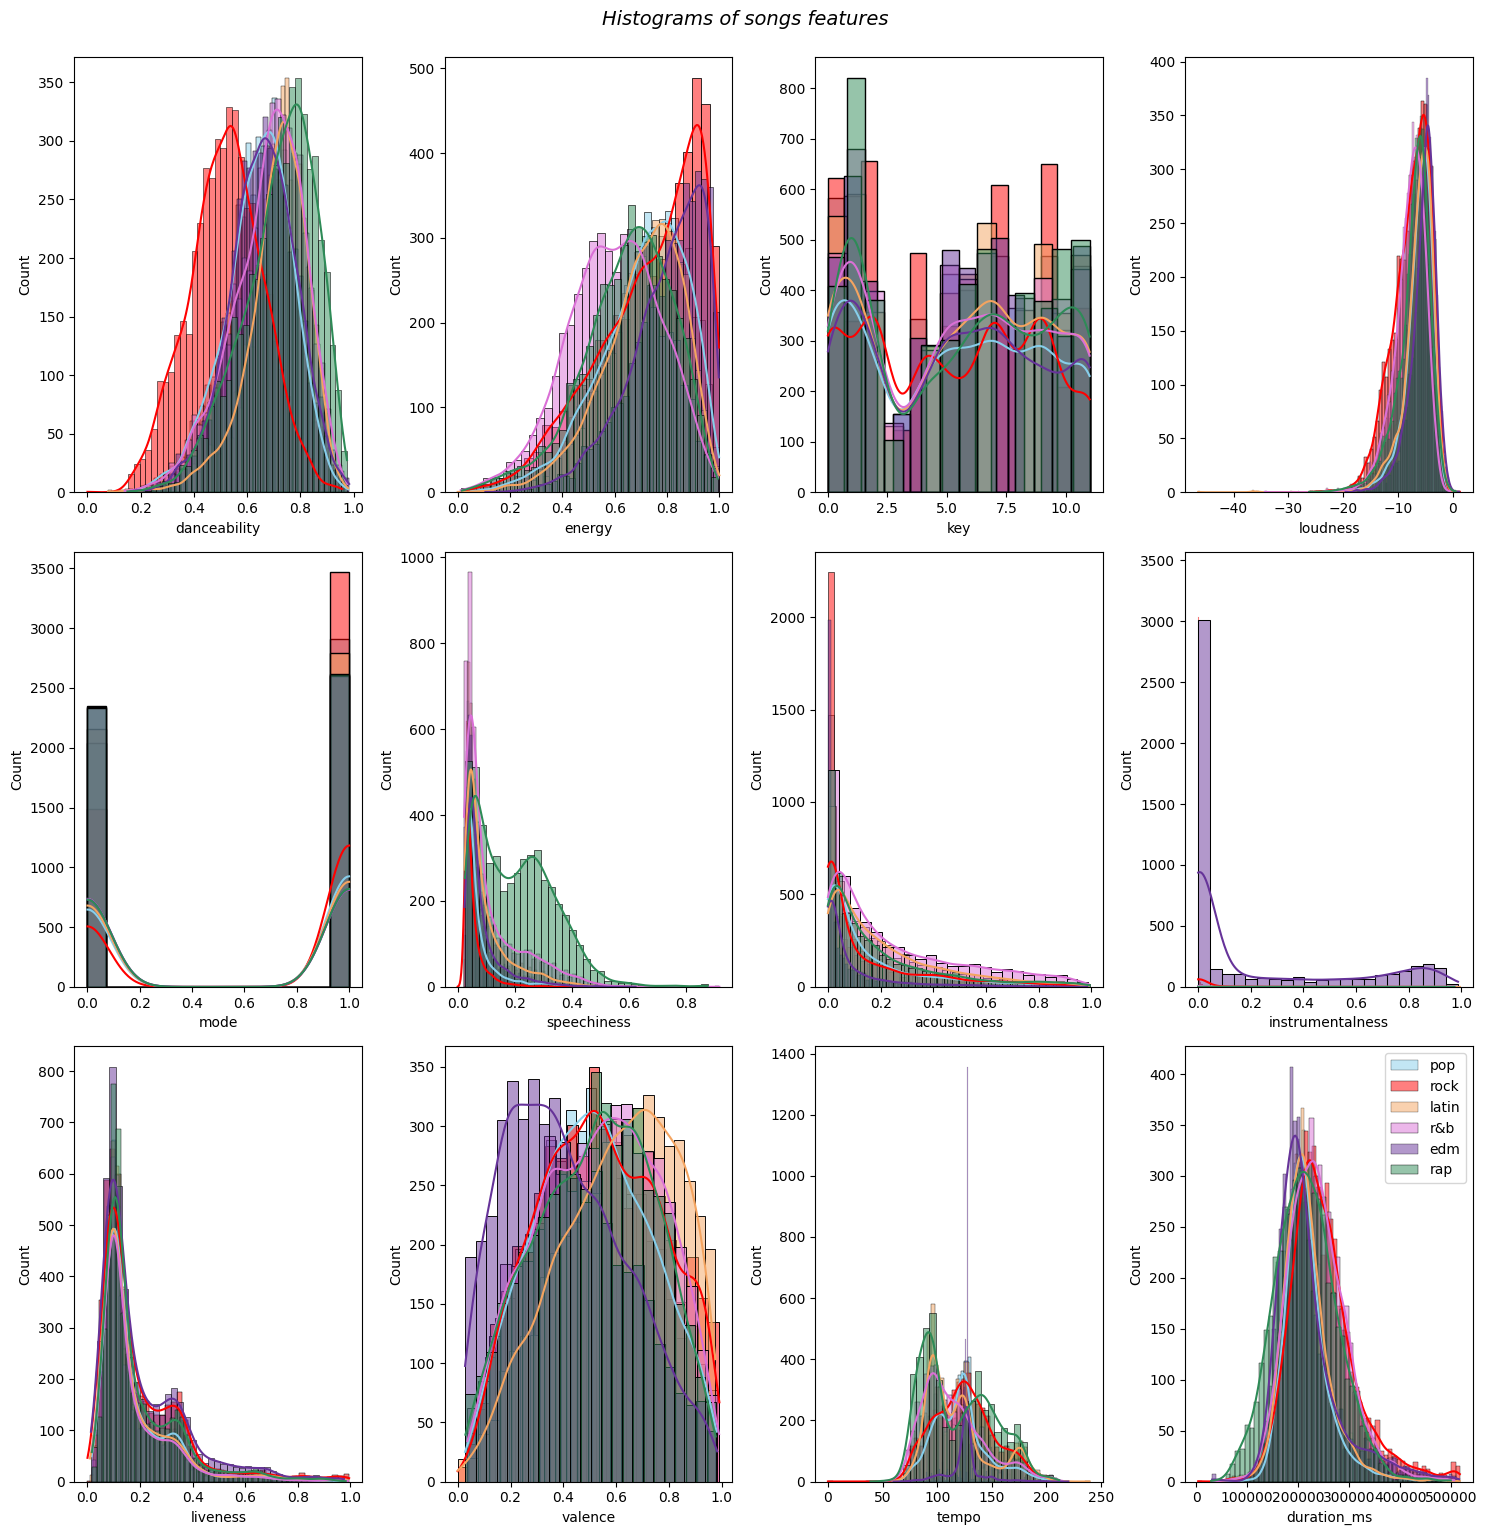

In [26]:
# without normalization
pop_df = songs_grouped[songs_grouped['playlist_genre']=='pop']
rock_df = songs_grouped[songs_grouped['playlist_genre']=='rock']
latin_df = songs_grouped[songs_grouped['playlist_genre']=='latin']
r_and_b_df = songs_grouped[songs_grouped['playlist_genre']=='r&b']
edm_df = songs_grouped[songs_grouped['playlist_genre']=='edm']
rap_df = songs_grouped[songs_grouped['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)
    
plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='10')
plt.show()

# Models

## KNeighborsClassifier

In [76]:
# KNeighborsClassifier
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train, songs_target_train)

    y_pred = knn_model.predict(songs_data_val)
    accuracy = accuracy_score(songs_target_val, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.sort_values('accuracy', ascending=False)

100%|██████████| 34/34 [00:20<00:00,  1.67it/s]


,k,accuracy
24,25,0.471050
32,33,0.470377
27,28,0.470153
21,22,0.469928
20,21,0.469928
33,34,0.469479
22,23,0.469479
31,32,0.469031
30,31,0.469031
26,27,0.468582


In [116]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=25)
knn_model.fit(songs_data_train, songs_target_train)
y_pred = knn_model.predict(songs_data_test)
accuracy = accuracy_score(songs_target_test, y_pred)
print(accuracy)

0.4723967684021544


In [117]:
# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,songs_data_train2,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

In [79]:
results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
22,23,0.466772


In [19]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=23)
knn_model.fit(songs_data_train2, songs_target_train2)
y_pred = knn_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print(accuracy)

0.46925493716337524


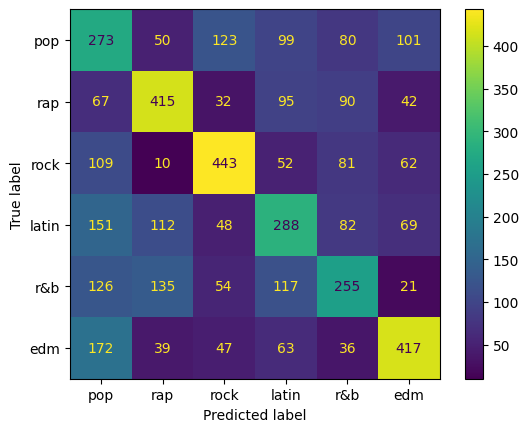

In [20]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

In [82]:
# optuna
# https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
# https://medium.com/@iqra.bismi/hyper-parameter-tuning-of-machine-learning-models-using-optuna-f1905547937f

### KNN on not normalized data

In [83]:
songs_data_train_nn, songs_data_test_nn, songs_target_train_nn, songs_target_test_nn = train_test_split(songs_data_non_normalized, songs_target, test_size=0.3, random_state=0)
songs_data_test_nn, songs_data_val_nn, songs_target_test_nn, songs_target_val_nn = train_test_split(songs_data_test_nn, songs_target_test_nn, test_size=0.5, random_state=0)

In [84]:
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train_nn, songs_target_train_nn)

    y_pred = knn_model.predict(songs_data_val_nn)
    accuracy = accuracy_score(songs_target_val_nn, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.loc[results_df['accuracy']==results_df['accuracy'].max()]

100%|██████████| 34/34 [00:07<00:00,  4.50it/s]


,k,accuracy
0,1,0.290171


In [105]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(songs_data_train_nn, songs_target_train_nn)
y_pred = knn_model.predict(songs_data_test_nn)
accuracy = accuracy_score(songs_target_test_nn, y_pred)
print(accuracy)

0.2888240574506284


As we see, results for not normalized data are much worse.

### KNN after log transformation

In [124]:
train_log = songs_data_train2.copy()
test_log = songs_data_test2.copy()

small_constant = 1e-10
train_log['speechiness'] = np.log(train_log['speechiness'] + small_constant)
train_log['acousticness'] = np.log(train_log['acousticness'] + small_constant)
train_log['liveness'] = np.log(train_log['liveness'] + small_constant)

test_log['speechiness'] = np.log(test_log['speechiness'] + small_constant)
test_log['acousticness'] = np.log(test_log['acousticness'] + small_constant)
test_log['liveness'] = np.log(test_log['liveness'] + small_constant)

test_log


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
12978,0.712106,0.610932,0.181818,0.797351,1.0,-3.365881,-3.719525,0.000000,-0.679189,0.733602,0.475806,0.501981
252,0.630722,0.905984,1.000000,0.897052,0.0,-2.683836,-2.276764,0.020724,-1.694261,0.401615,0.513895,0.424405
30844,0.765005,0.504913,0.818182,0.813591,1.0,-1.288808,-0.619470,0.000003,-2.259356,0.422805,0.384105,0.376978
14635,0.461851,0.720951,0.454545,0.791484,1.0,-3.179362,-7.604935,0.000000,-1.092606,0.733602,0.676474,0.355794
10163,0.851475,0.429900,0.090909,0.736835,1.0,-1.047646,-0.467191,0.000000,-2.298577,0.727548,0.338223,0.286692
...,...,...,...,...,...,...,...,...,...,...,...,...
8178,0.712106,0.546921,0.090909,0.807598,1.0,-1.772341,-2.927679,0.000000,-2.684240,0.676085,0.656269,0.455926
10077,0.912513,0.606931,1.000000,0.856903,1.0,-1.379780,-3.251079,0.000000,-1.009344,0.166498,0.584622,0.483105
27560,0.744659,0.849974,0.090909,0.847579,1.0,-3.028958,-2.165539,0.000002,-3.245327,0.375378,0.517975,0.369399
14084,0.629705,0.702948,0.909091,0.776020,0.0,-2.861384,-5.545902,0.206237,-1.809997,0.715439,0.480467,0.883085


In [120]:
# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,train_log,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
19,20,0.406495


In [125]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(train_log, songs_target_train2)
y_pred = knn_model.predict(test_log)
accuracy = accuracy_score(songs_target_test2,y_pred)
print(accuracy)

0.41337522441651703


## Naive bayes classifier

In [17]:
# Naive bayes classifier
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train, songs_target_train)
y_pred = naive_bayes_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)

print(accuracy)

0.4506283662477558


In [16]:
# accuracy on test set
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train2, songs_target_train2)
y_pred = naive_bayes_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)

print(accuracy)

0.44367145421903054


Each feature has the same influence on the decision.

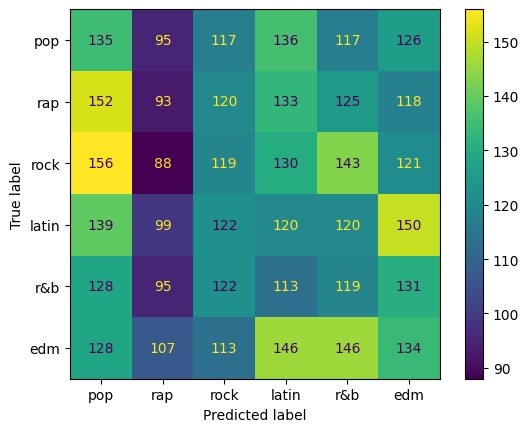

In [18]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Decision tree

In [27]:
# Decision tree
decision_tree_model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [7,9,11],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [6,7,8]
}

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(songs_data_train, songs_target_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best params:", best_params)

y_pred = best_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

Best params: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 8}
0.4649910233393178


In [28]:
# feature importances
best_model.feature_importances_

array([0.17147225, 0.08722701, 0.00625039, 0.07516389, 0.00270852,
       0.19413191, 0.0517185 , 0.09632431, 0.00706641, 0.06269472,
       0.16992411, 0.07531798])

In [29]:
feature_importances_dt = pd.Series(best_model.feature_importances_, index=songs_data_train.columns)
feature_importances_dt

danceability        0.171472
energy              0.087227
key                 0.006250
loudness            0.075164
mode                0.002709
speechiness         0.194132
acousticness        0.051718
instrumentalness    0.096324
liveness            0.007066
valence             0.062695
tempo               0.169924
duration_ms         0.075318
dtype: float64

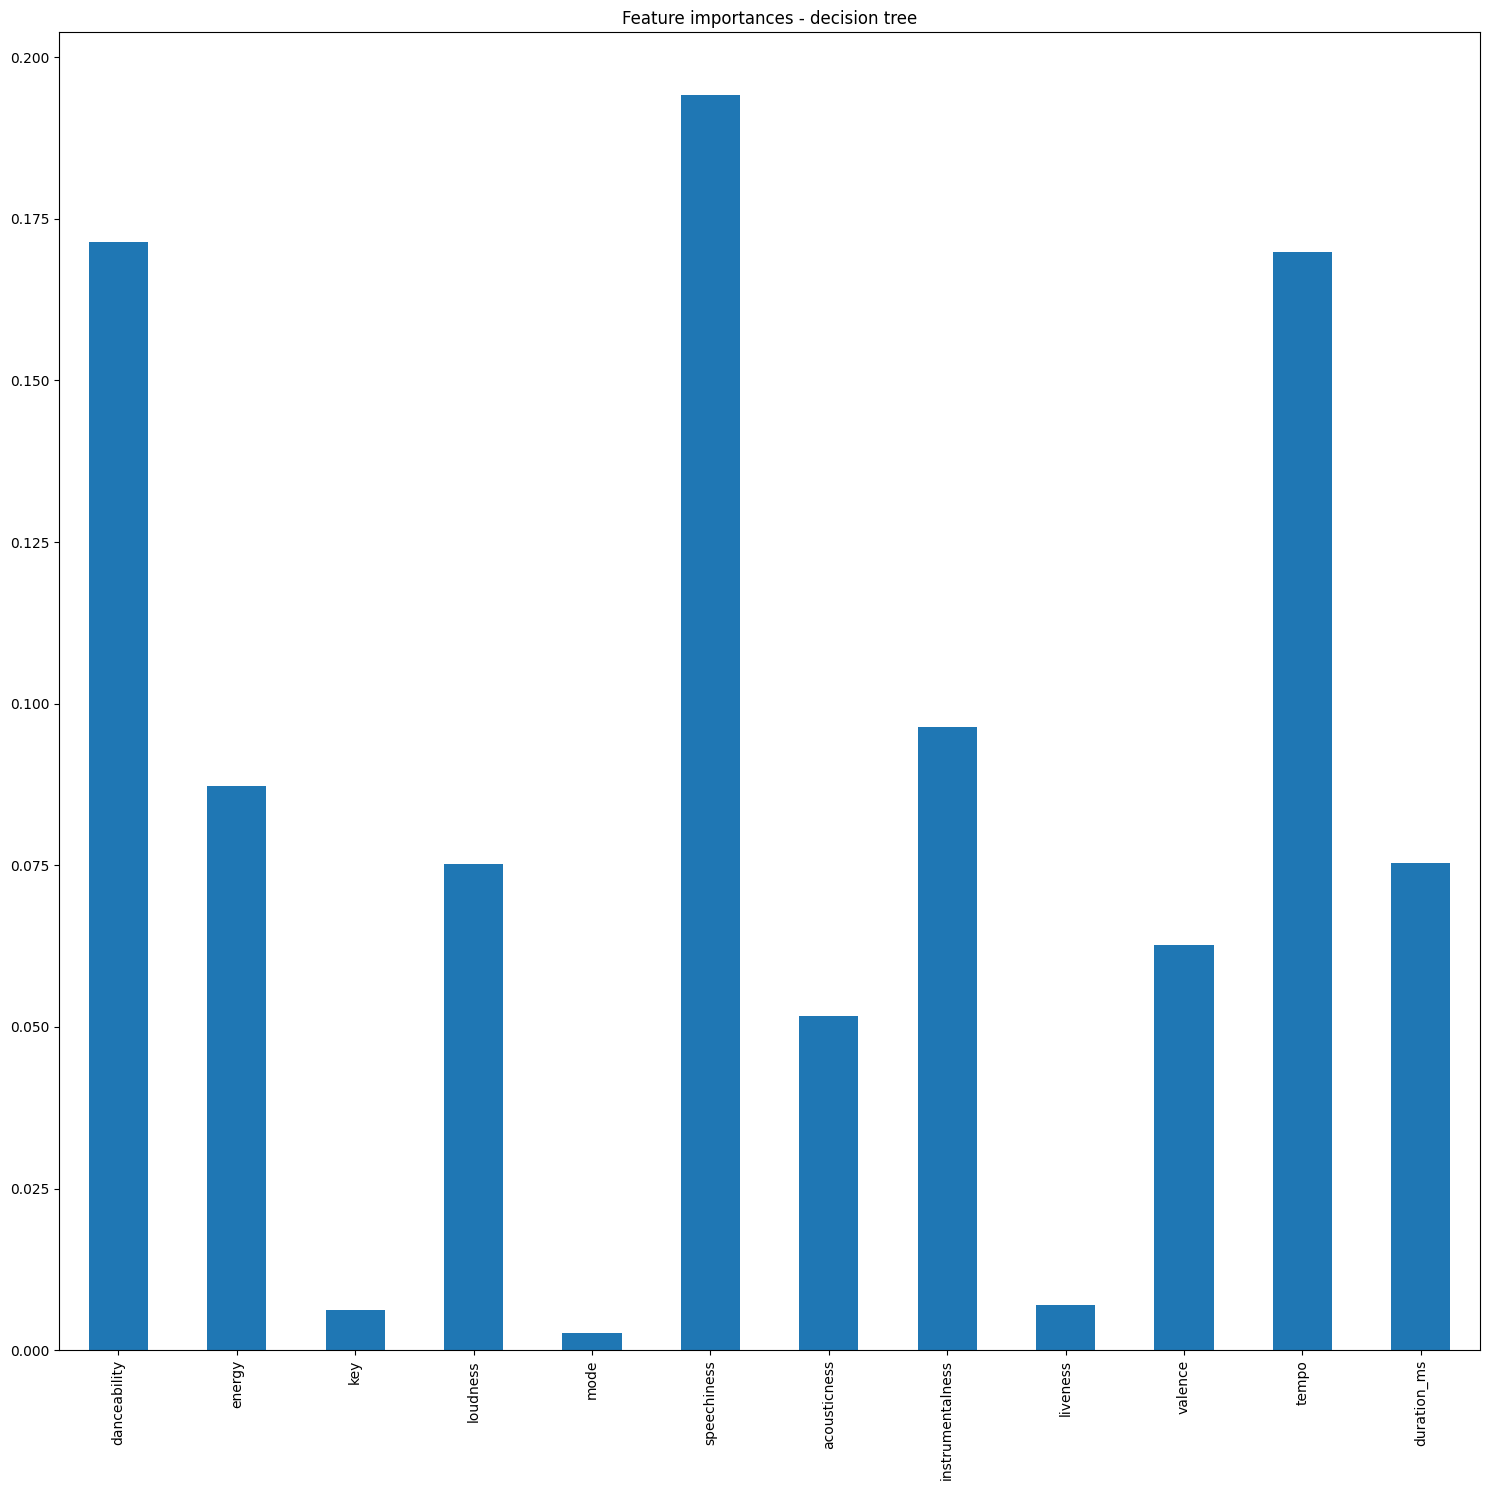

In [30]:
fig, ax = plt.subplots()
feature_importances_dt.plot.bar(ax=ax)
ax.set_title("Feature importances - decision tree")
fig.tight_layout()

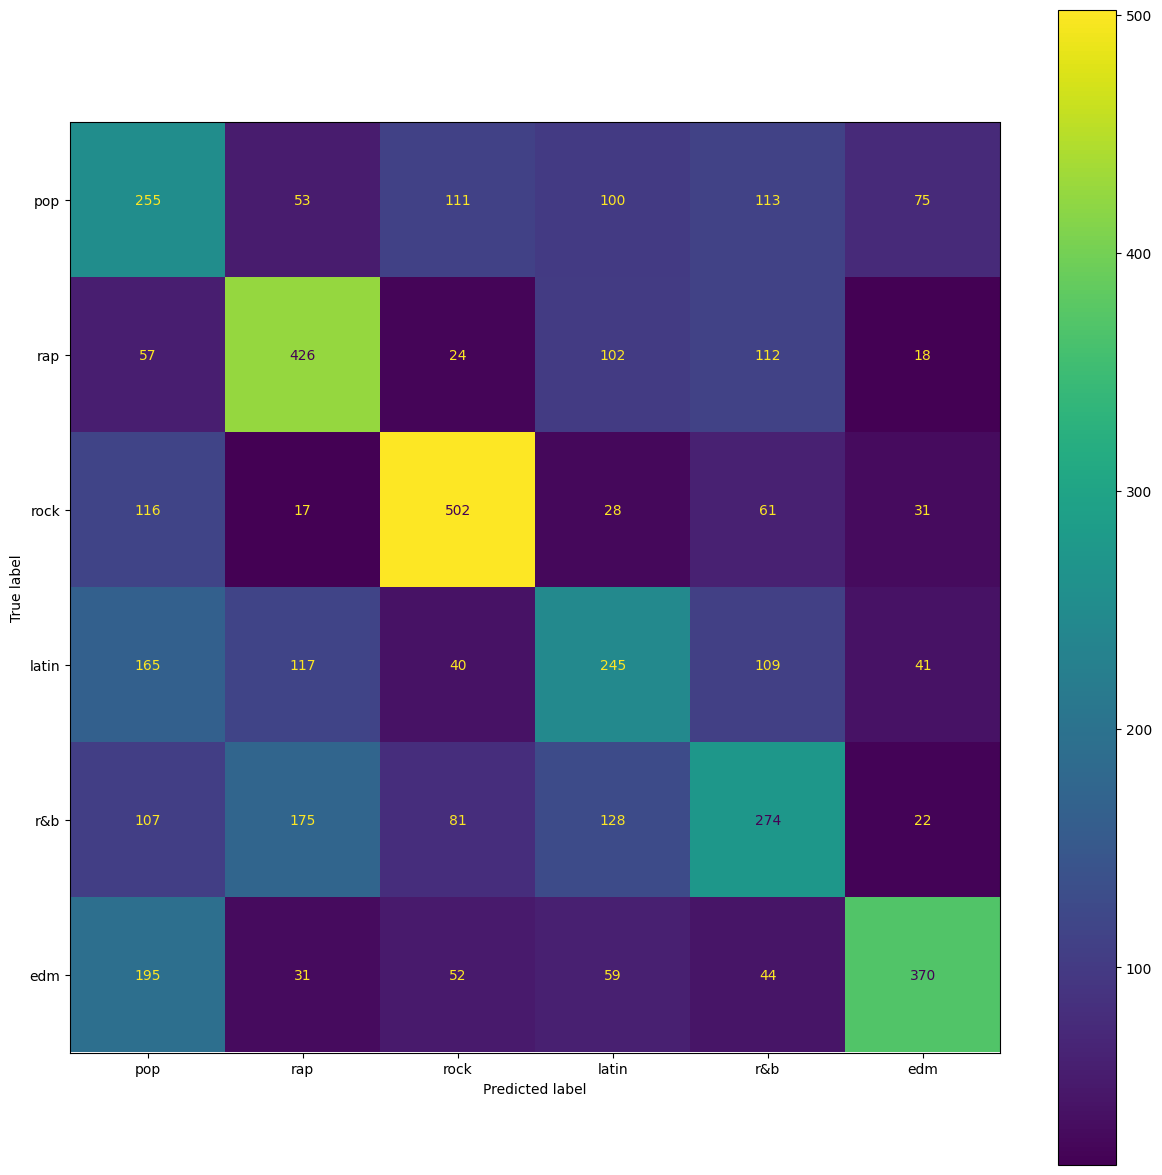

In [31]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Random forest

In [32]:
def make_random_search(model, param_distributions):
    return RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=10,
        cv=3,
        scoring='accuracy',  # Use accuracy as the metric
        random_state=42
    )

In [33]:
# Random forest
random_forest_model = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample between 50 and 200
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = make_random_search(random_forest_model, param_dist)
random_search.fit(songs_data_train, songs_target_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model from the search
best_random_forest_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred = best_random_forest_model.predict(songs_data_val)

# Calculate accuracy
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)


Best Hyperparameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 171}
0.5617145421903053


In [36]:
# feature importances
best_random_forest_model.feature_importances_

array([0.12770483, 0.09465467, 0.0331147 , 0.08514133, 0.0091516 ,
       0.13257023, 0.08801085, 0.07927309, 0.05551173, 0.08769245,
       0.11990545, 0.08726907])

In [38]:
feature_importances_rf = pd.Series(best_random_forest_model.feature_importances_, index=songs_data_train.columns)
feature_importances_rf

danceability        0.127705
energy              0.094655
key                 0.033115
loudness            0.085141
mode                0.009152
speechiness         0.132570
acousticness        0.088011
instrumentalness    0.079273
liveness            0.055512
valence             0.087692
tempo               0.119905
duration_ms         0.087269
dtype: float64

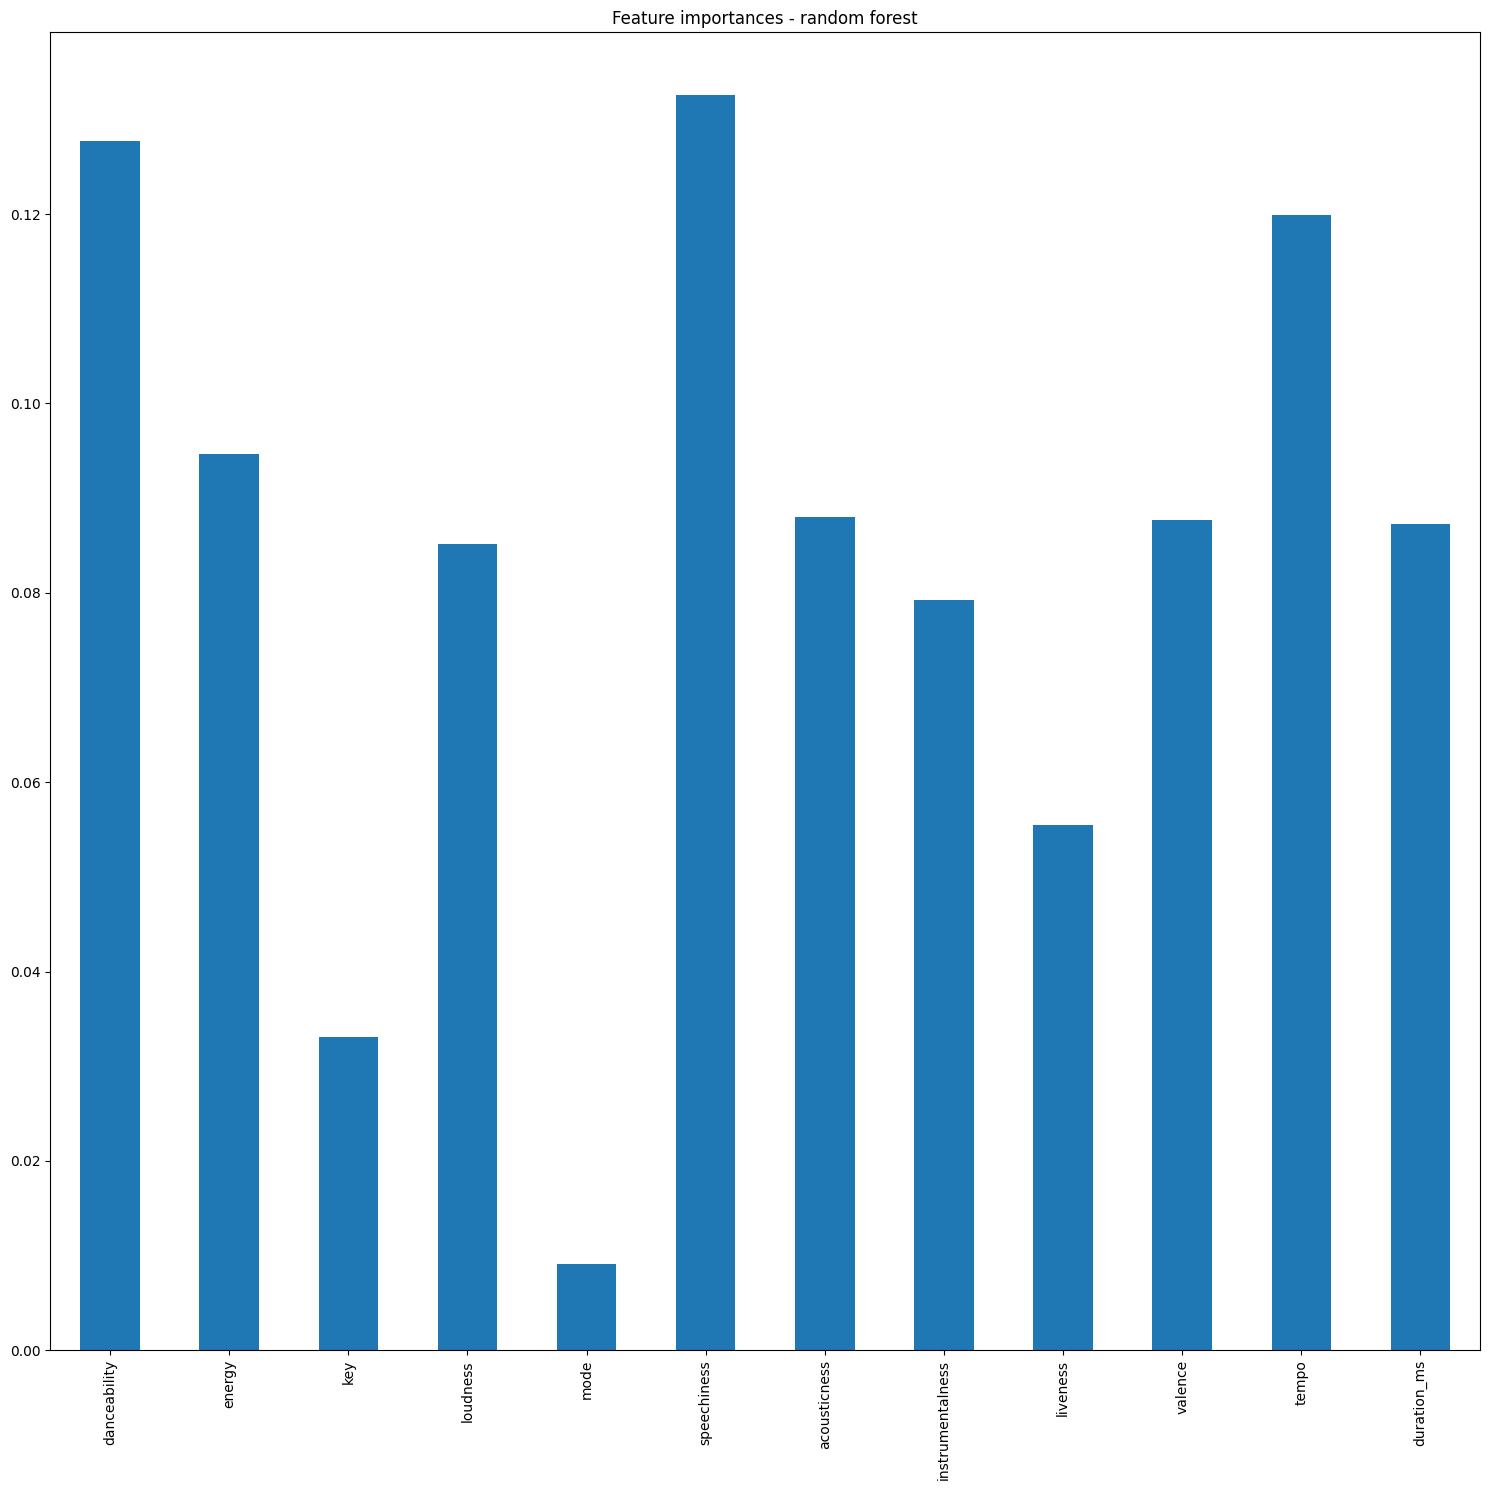

In [39]:
fig, ax = plt.subplots()
feature_importances_rf.plot.bar(ax=ax)
ax.set_title("Feature importances - random forest")
fig.tight_layout()

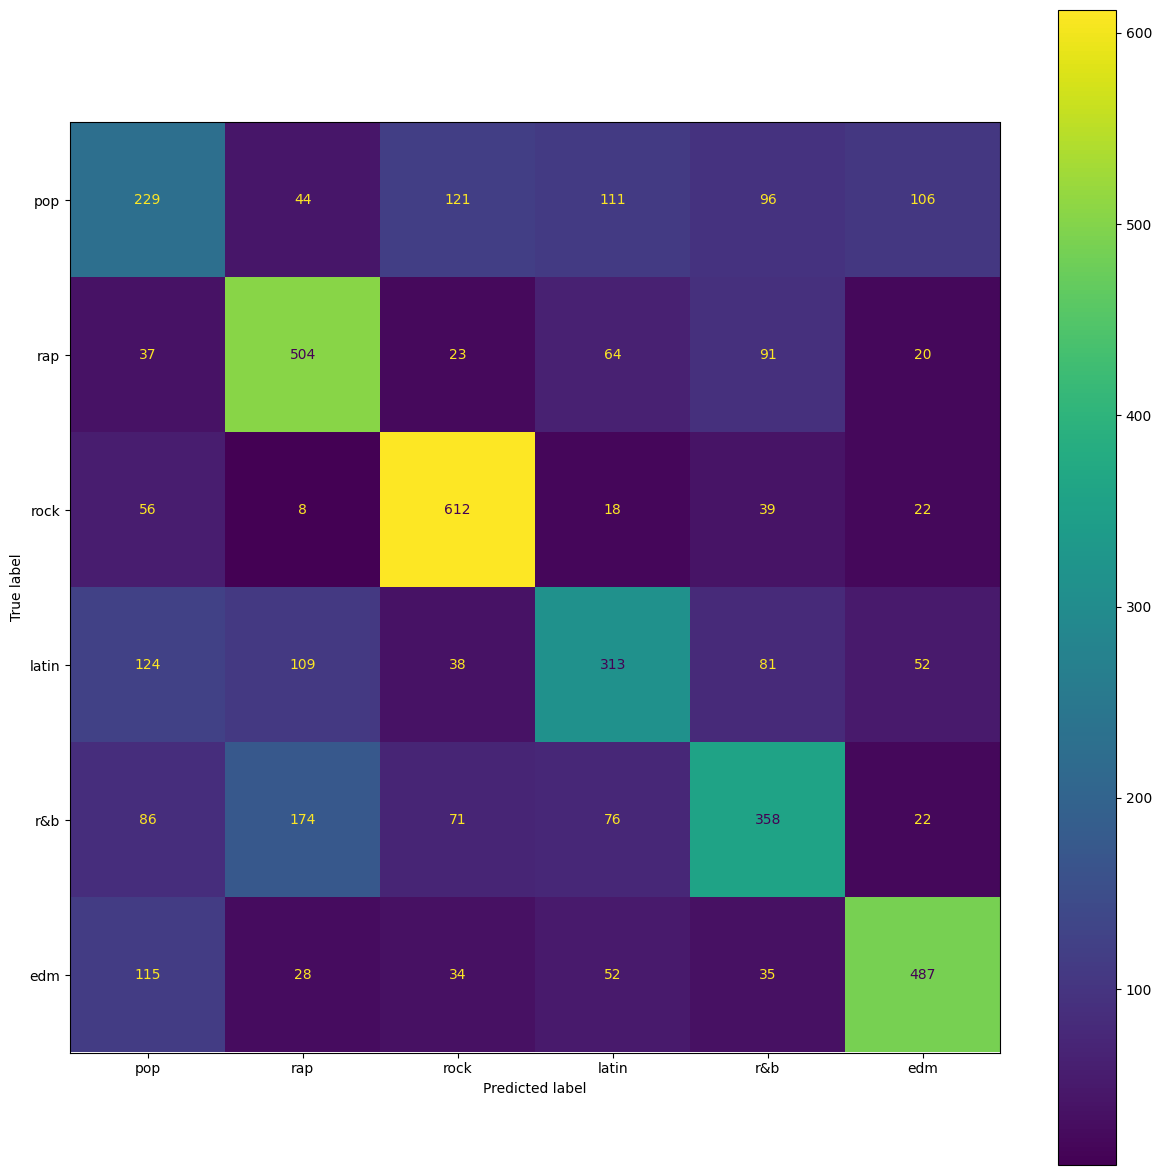

In [40]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## KNN on important features

Let's try to consider only the features with high `feature importance` in both random forest and decision trees and use them for the KNN classifier

In [41]:
feature_importances = feature_importances_dt + feature_importances_rf
print(feature_importances.sort_values(ascending=False))

speechiness         0.326702
danceability        0.299177
tempo               0.289830
energy              0.181882
instrumentalness    0.175597
duration_ms         0.162587
loudness            0.160305
valence             0.150387
acousticness        0.139729
liveness            0.062578
key                 0.039365
mode                0.011860
dtype: float64


In [ ]:
res = []
for n_features in tqdm(np.arange(1, len(feature_importances))):
    important_columns = feature_importances.sort_values(ascending=False).index[:n_features]
    important_data = songs_data[important_columns]
    important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target, test_size=0.15, random_state=0)
    # cross validation
    for k in np.arange(1,40):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        er = cross_val_score(knn_model,important_data_train,important_target_train,cv=5)
        res.append({'n_feat': n_features, 'K':k, 'err_rate': er.mean()})


100%|██████████| 11/11 [15:04<00:00, 82.20s/it] 


In [ ]:
# find best k for each number of features
results_df = pd.DataFrame(res)
results_df = results_df.sort_values('err_rate', ascending=False)
results_df = results_df.groupby('n_feat').head(1)
results_df = results_df.reset_index(drop=True)
results_df

,n_feat,K,err_rate
0,9,36,0.501069
1,8,38,0.499406
2,10,30,0.495248
3,7,33,0.486653
4,11,38,0.472356
5,6,33,0.472158
6,5,26,0.458218
7,4,33,0.447485
8,3,38,0.423129
9,2,39,0.344515


In [ ]:
important_columns = feature_importances.sort_values(ascending=False).index[:9]
important_data = songs_data_train[important_columns]
important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target_train, test_size=0.15, random_state=0)

knn_model = KNeighborsClassifier(n_neighbors=32)
knn_model.fit(important_data_train, important_target_train)
y_pred = knn_model.predict(important_data_test)
accuracy = accuracy_score(important_target_test, y_pred)
print(accuracy)

0.5032051282051282


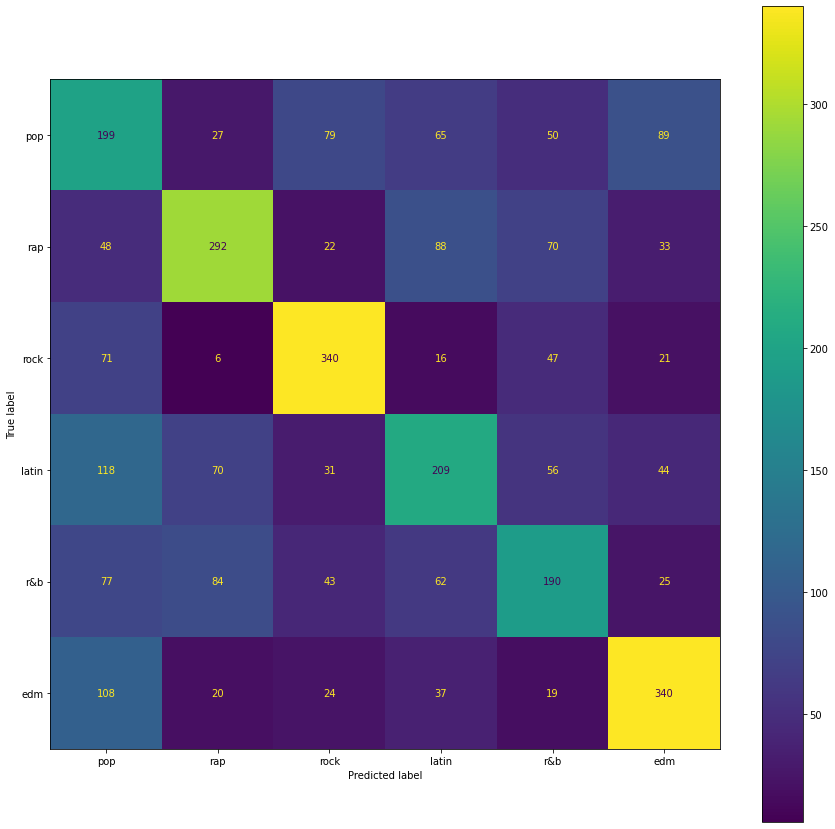

In [ ]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(important_target_test,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Support Vector Machine

In [42]:
# Support Vector Machine
clf = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)
clf.fit(songs_data_train, songs_target_train)
y_pred = clf.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5175044883303411


In [43]:
svm_model = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 10),        # Randomly sample C from a uniform distribution between 0.1 and 10
    'gamma': ['scale', 'auto'],   # Choose between 'scale' and 'auto' for gamma
    'coef0': uniform(0, 1)         # Randomly sample coef0 from a uniform distribution between 0 and 1
}

random_search = make_random_search(svm_model, param_dist)
random_search.fit(songs_data_train, songs_target_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best SVM model from the search
best_svm_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_svm = best_svm_model.predict(songs_data_val)

# Calculate accuracy
accuracy_svm = accuracy_score(songs_target_val, y_pred_svm)
print("Validation Accuracy (SVM):", accuracy_svm)


Best Hyperparameters: {'C': 3.845401188473625, 'coef0': 0.9507143064099162, 'gamma': 'scale'}
Validation Accuracy (SVM): 0.5276032315978456


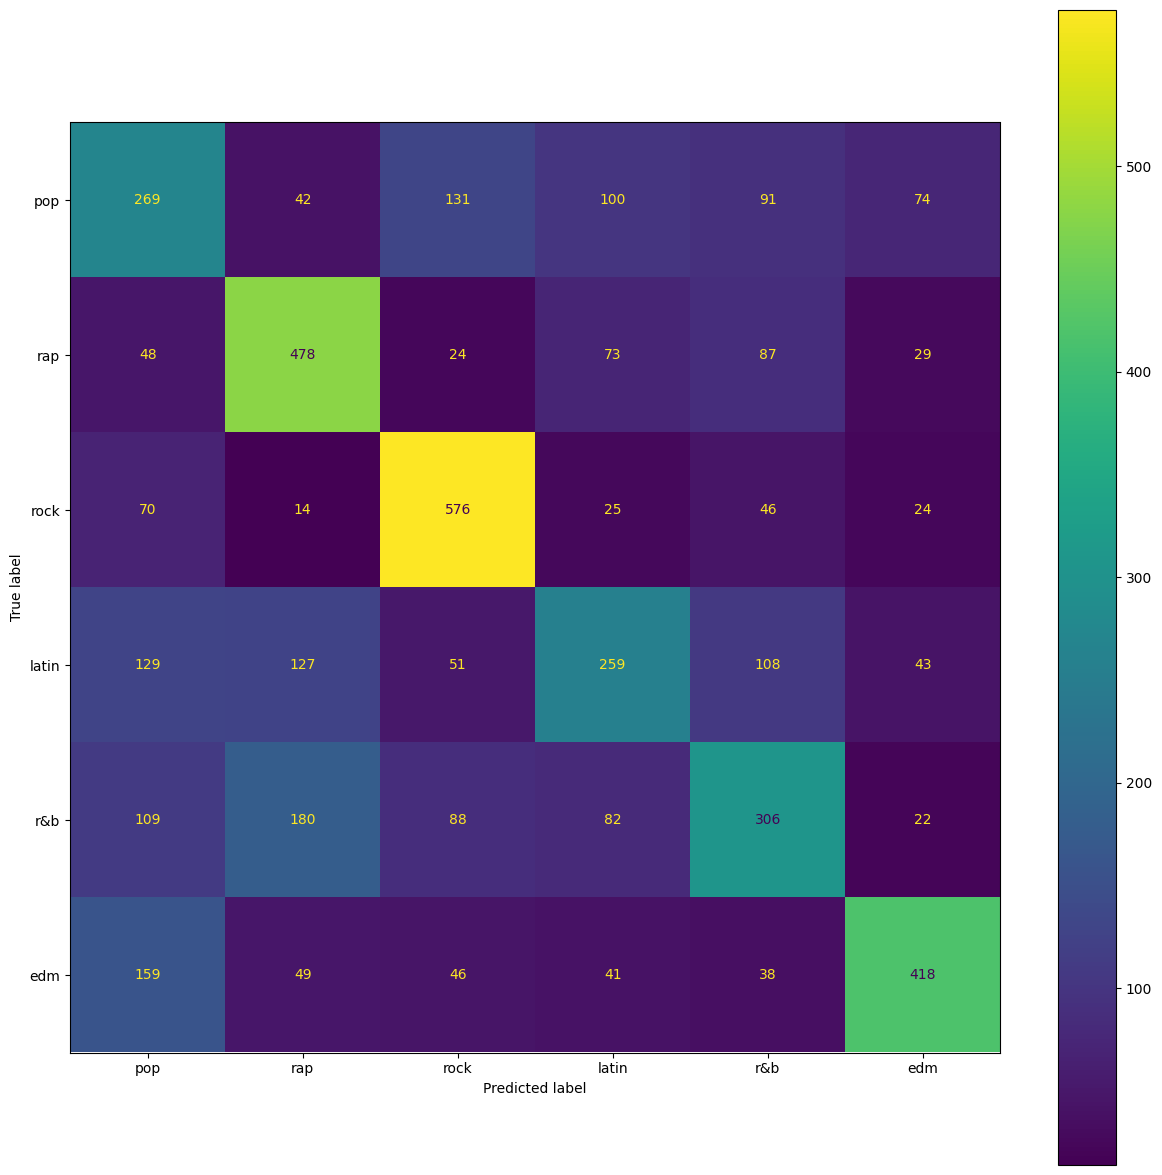

In [44]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Multiclass Logistic Regression

In [ ]:
mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
mlr.fit(songs_data_train, songs_target_train)
y_pred = mlr.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.4762118491921005


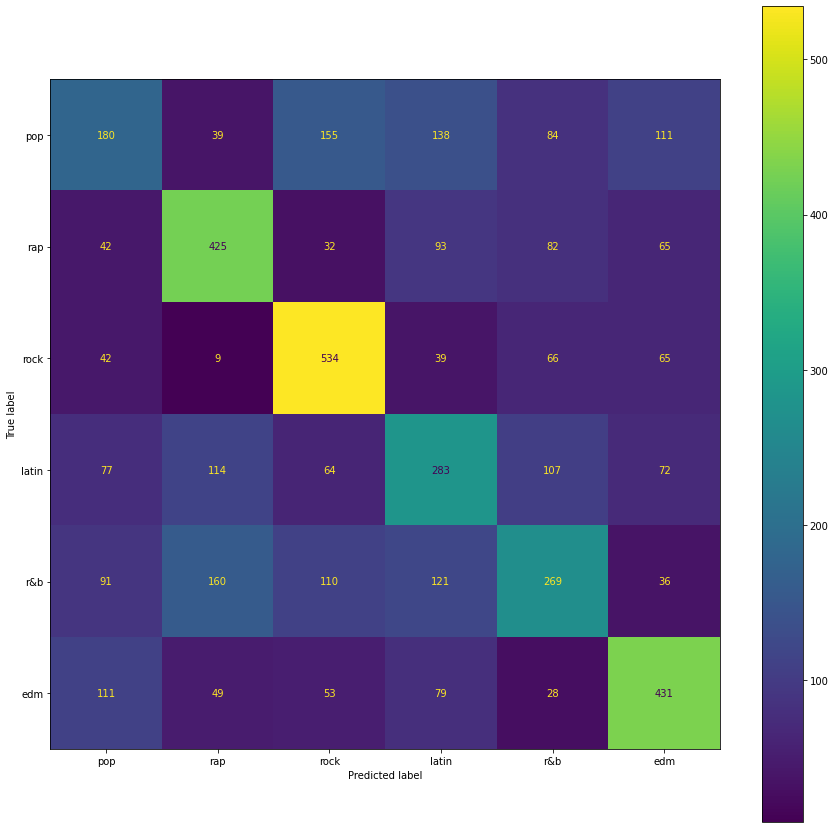

In [ ]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## AdaBoost


In [45]:
# AdaBoost
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, learning_rate=1, random_state=42)
adaboost_model.fit(songs_data_train, songs_target_train)
y_pred = adaboost_model.predict(songs_data_val)


accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.4903500897666068


In [46]:
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample between 50 and 200
    'learning_rate': uniform(0.01, 1.0),  # Randomly sample learning_rate from a uniform distribution
}

random_search = make_random_search(adaboost_model, param_dist)
random_search.fit(songs_data_train, songs_target_train)

print("Best Hyperparameters:", random_search.best_params_)
best_adaboost_model = random_search.best_estimator_
y_pred = best_adaboost_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

Best Hyperparameters: {'learning_rate': 0.46924889196586717, 'n_estimators': 166}
0.5069569120287253


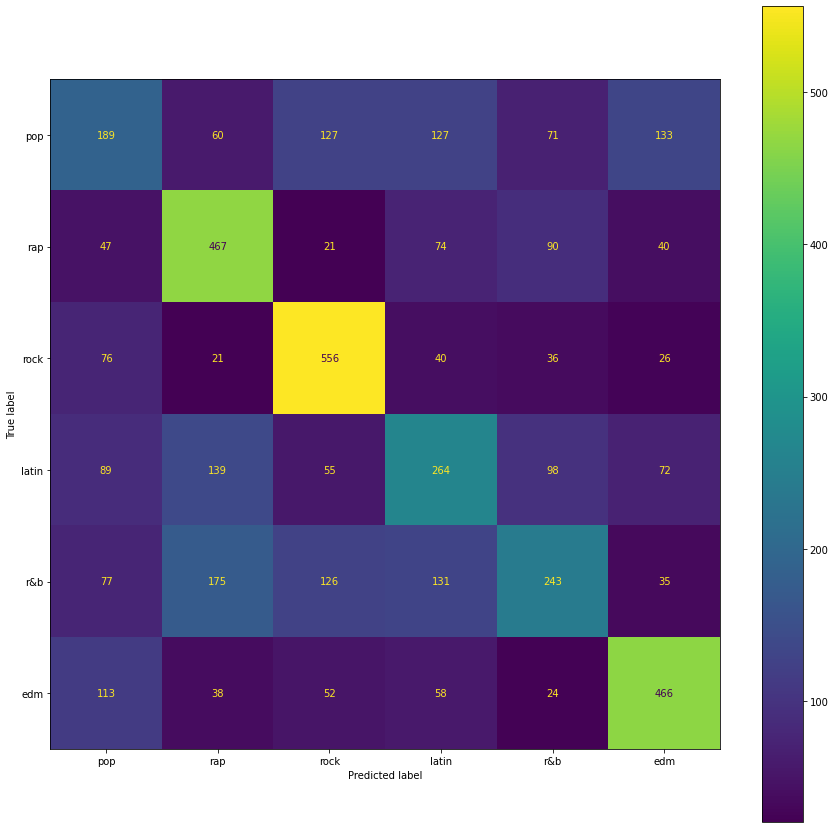

In [ ]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Bootstrap Aggregating

In [47]:
#Bagging (Bootstrap Aggregating)
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, n_estimators=50, random_state=42)
bagging_model.fit(songs_data_train, songs_target_train)
y_pred = bagging_model.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5412926391382405


In [49]:
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample between 50 and 200
    'max_samples': uniform(0.1, 1.0),  # Randomly sample max_samples from a uniform distribution
    'max_features': uniform(0.1, 1.0)  # Randomly sample max_features from a uniform distribution
}

random_search = make_random_search(bagging_model, param_dist)

random_search.fit(songs_data_train, songs_target_train)
print("Best Hyperparameters:", random_search.best_params_)
best_bagging_model = random_search.best_estimator_
y_pred = best_bagging_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/site-packages/sklearn/utils/_p

Best Hyperparameters: {'max_features': 0.8796910002727693, 'max_samples': 0.696850157946487, 'n_estimators': 171}
0.553411131059246


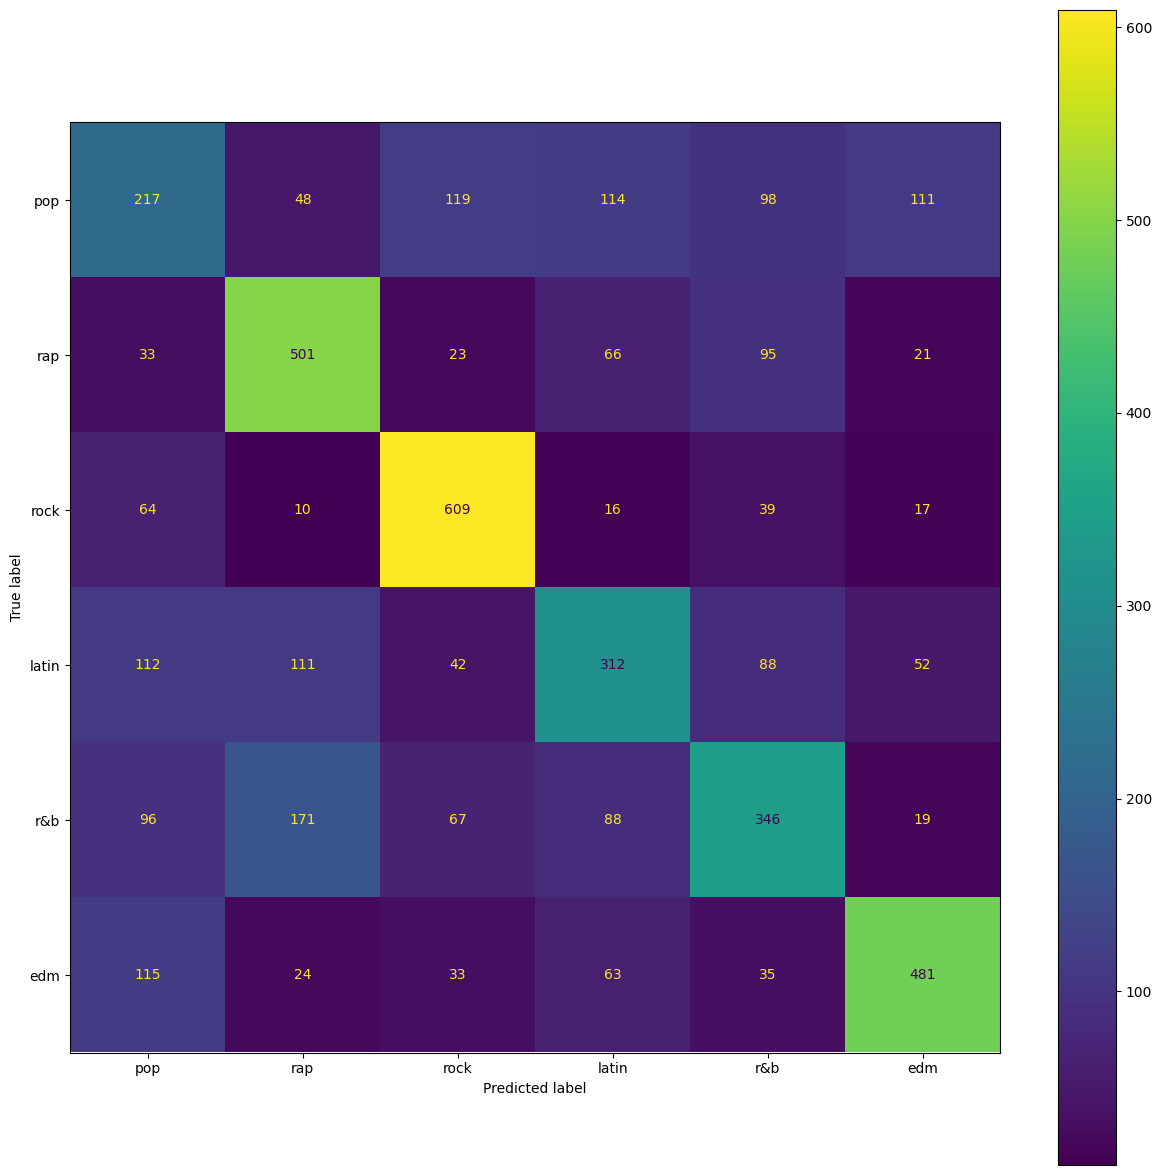

In [50]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## TO DO

XGBoost